In [2]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp

sys.path.append("/home/sergey/tools/sclitr/")
import sclitr as sl

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

# Trunk

In [2]:
adata_m = sc.read_h5ad(f"{DATA_PATH}/anndatas/mesenchyme_trunk_E13_reference.h5ad")

adata_n = sc.read_h5ad(f"{DATA_PATH}/anndatas/neurons_glia_trunk_E13_reference.h5ad")

adata_o = sc.read_h5ad(f"{DATA_PATH}/anndatas/other_cells_trunk_E13_reference.h5ad")
adata_o.obs.celltype_l2 = adata_o.obs.celltype_l2.cat.rename_categories({"Doublets": "Doublet"})

adata_g = sc.read_h5ad(f"{DATA_PATH}/anndatas/glia_trunk_E13_reference.h5ad")

adata_n = adata_n[~adata_n.obs_names.isin(adata_g.obs_names)]
adata_g = adata_g[adata_g.obs.celltype_l2 != "Doublet"]
adata_o = adata_o[adata_o.obs.celltype_l2 != "Doublet"]

adata = sc.read_h5ad(f"{DATA_PATH}/anndatas/trunk_E13_reference.h5ad")
adata = adata[~adata.obs.celltype_l2.isin(["Doublets", "Doublet"])]

for adata_ in [adata, adata_o, adata_m, adata_n, adata_g]:
    adata_.obs["perturbation"] = "False"

In [3]:
adata_n_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/trunk_E13_neurons_and_glia.h5ad")
adata_o_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/trunk_E13_other.h5ad")
adata_g_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/trunk_E13_glia.h5ad")
adata_m_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/trunk_E13_mesenchyme.h5ad")

adata_full_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/trunk_E13.h5ad")

adata_n_crispr = adata_n_crispr[~adata_n_crispr.obs_names.isin(adata_g_crispr.obs_names)]
adata_g_crispr = adata_g_crispr[adata_g_crispr.obs.celltype_l2 != "Doublet"]
adata_o_crispr = adata_o_crispr[adata_o_crispr.obs.celltype_l2 != "Doublet"]

adata_full_crispr = adata_full_crispr[~adata_full_crispr.obs.celltype_l2.isin(["Doublets", "Doublet"])]

for adata_ in [adata_full_crispr, adata_o_crispr, adata_m_crispr, adata_n_crispr, adata_g_crispr]:
    adata_.obs["perturbation"] = "True"

In [6]:
adata_n = adata_n.raw.to_adata().concatenate(adata_n_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata_m = adata_m.raw.to_adata().concatenate(adata_m_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata_g = adata_g.raw.to_adata().concatenate(adata_g_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata_o = adata_o.raw.to_adata().concatenate(adata_o_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata = adata.raw.to_adata().concatenate(adata_full_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)

for adata_ in [adata, adata_o, adata_m, adata_n, adata_g]:
    adata_.var = pd.DataFrame(index=adata_.var_names)
    adata_.obs["E7.5:clones"] = adata_.obs["E7.5:clones"].fillna("NA")
    adata_.obs["E8.5:clones"] = adata_.obs["E8.5:clones"].fillna("NA")

## Joint analysis of clones from both fates

In [5]:
def create_fake_anndata(adata):
    clone_ids = adata.obs[["E7.5:clones", "E8.5:clones", "celltype_l2", "celltype_l3", "CRISPR:predicted"]]
    clone_ids["E7.5:clones"] = [f"E7.5:{i}" if i != "NA" else "NA" for i in clone_ids["E7.5:clones"]]
    clone_ids["E8.5:clones"] = [f"E8.5:{i}" if i != "NA" else "NA" for i in clone_ids["E8.5:clones"]]
    double_clones = clone_ids[(clone_ids["E7.5:clones"] != "NA") & (clone_ids["E8.5:clones"] != "NA")]
    double_clones_cells = double_clones.index
    single_clones = clone_ids[~clone_ids.index.isin(double_clones.index)]

    single_clones["clones"] = (
        single_clones["E7.5:clones"] * (single_clones["E7.5:clones"] != "NA") +
        single_clones["E8.5:clones"] * (single_clones["E8.5:clones"] != "NA")
    ).replace("", "NA")
    del (single_clones["E7.5:clones"], single_clones["E8.5:clones"])

    double_clones = pd.concat([
        pd.DataFrame(np.matrix(double_clones.values[:, [0, 2, 3]]), index=double_clones.index + "_0",  columns=double_clones.columns[[0, 2, 3]]),
        pd.DataFrame(np.matrix(double_clones.values[:, [0, 2, 3]]), index=double_clones.index + "_1",  columns=double_clones.columns[[1, 2, 3]])
    ]).fillna("NA")

    double_clones["clones"] = (
        double_clones["E7.5:clones"] * (double_clones["E7.5:clones"] != "NA") +
        double_clones["E8.5:clones"] * (double_clones["E8.5:clones"] != "NA")
    ).replace("", "NA")
    del (double_clones["E7.5:clones"], double_clones["E8.5:clones"])

    return sc.AnnData(
        obsm={
            "X_pca_harmony": np.concatenate([
                np.array(adata[single_clones.index].obsm["X_pca_harmony"]),
                np.array(adata[double_clones_cells].obsm["X_pca_harmony"]),
                np.array(adata[double_clones_cells].obsm["X_pca_harmony"]),
            ], axis=0)
        },
        obs=pd.concat([single_clones, double_clones]),
    )

In [ ]:
clonal_nn_kwargs = {
    "obs_name": "clones",
    "obsm_name": "X_pca_harmony",
    "min_size": 10,
}

adata_m_fake = create_fake_anndata(adata_m)
adata_g_fake = create_fake_anndata(adata_g)
adata_o_fake = create_fake_anndata(adata_o)
adata_n_fake = create_fake_anndata(adata_n)

adata_m_clonal = sl.tl.clonal_nn(adata_m_fake, **clonal_nn_kwargs)
adata_n_clonal = sl.tl.clonal_nn(adata_n_fake, **clonal_nn_kwargs)
adata_g_clonal = sl.tl.clonal_nn(adata_g_fake, **clonal_nn_kwargs)
adata_o_clonal = sl.tl.clonal_nn(adata_o_fake, **clonal_nn_kwargs)

adata_clonal = adata_m_clonal.concatenate(
    [adata_n_clonal, adata_g_clonal, adata_o_clonal],
    join="outer",
    batch_key=None,
    index_unique=None,
    fill_value=0,
)

for ct in ["celltype_l2", "celltype_l3", "CRISPR:predicted"]:
    ct_list = []
    for adata_ in [adata_m_fake, adata_n_fake, adata_g_fake, adata_o_fake]:
        ct_list += list(adata_.obs[ct].astype(str))
    adata_clonal.obs[ct] = ct_list
    adata_clonal.obs[ct] = adata_clonal.obs[ct].astype("category")

clones = sl.tl.clone2vec(
    adata_clonal,
    obs_name=f"clones",
    device="cuda:0",
    fill_ct="celltype_l2",
)

sc.pp.neighbors(clones, use_rep="word2vec")
sc.tl.umap(clones)
clones.obs["injection_time"] = [i.split(":")[0] for i in clones.obs_names]

  1%|          | 2/200 [00:44<1:13:24, 22.25s/it]

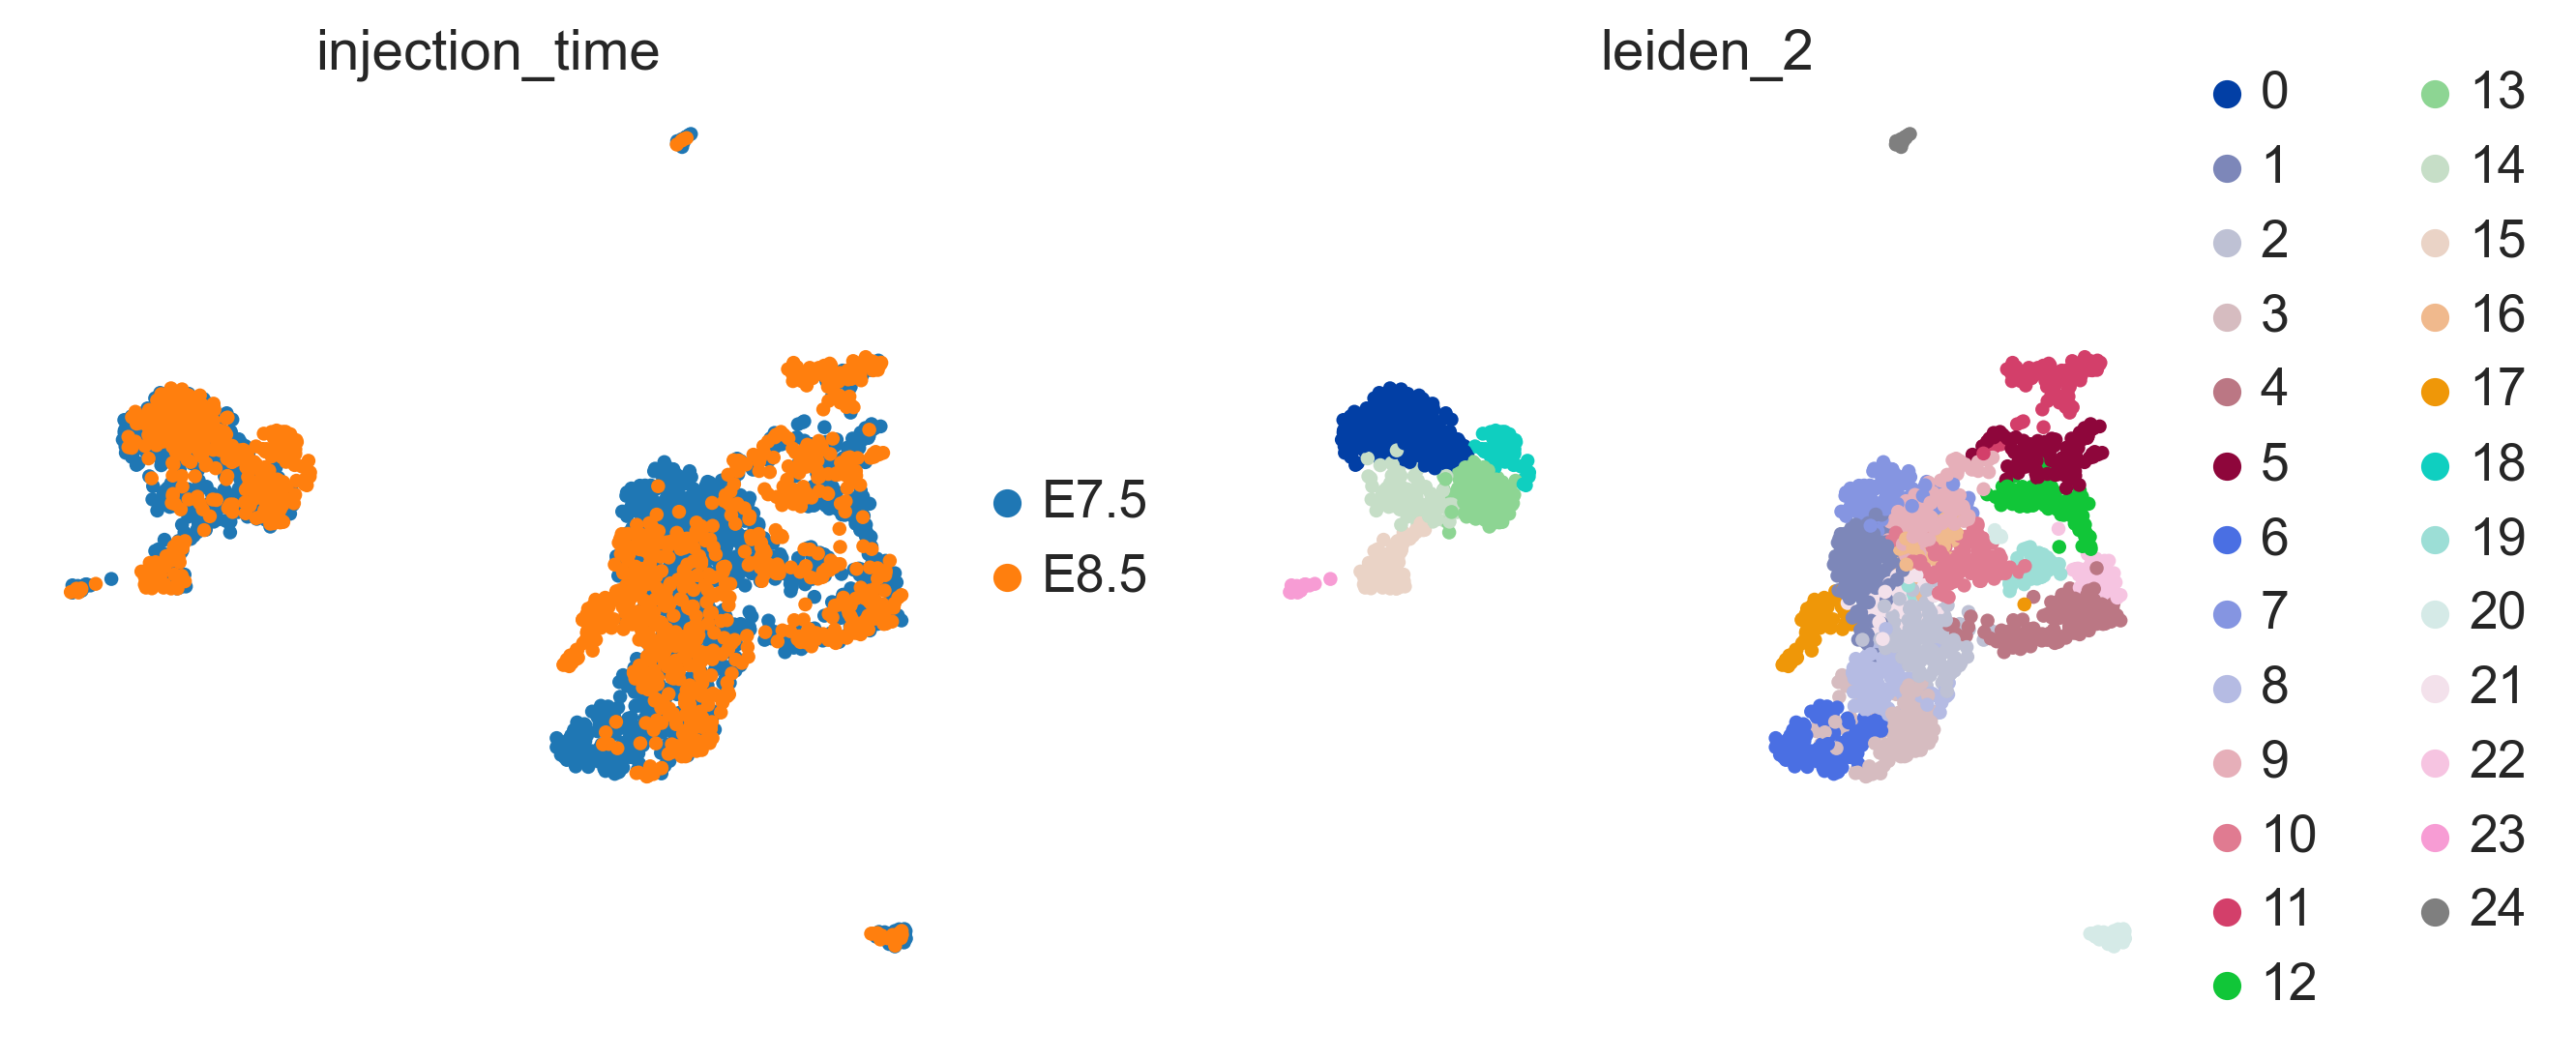

In [27]:
for resolution in [0.5, 1, 2]:
    sc.tl.leiden(
        clones,
        resolution=resolution,
        key_added=f"leiden_{resolution}",
    )
sc.pl.umap(clones, color=["injection_time", "leiden_2"], frameon=False)

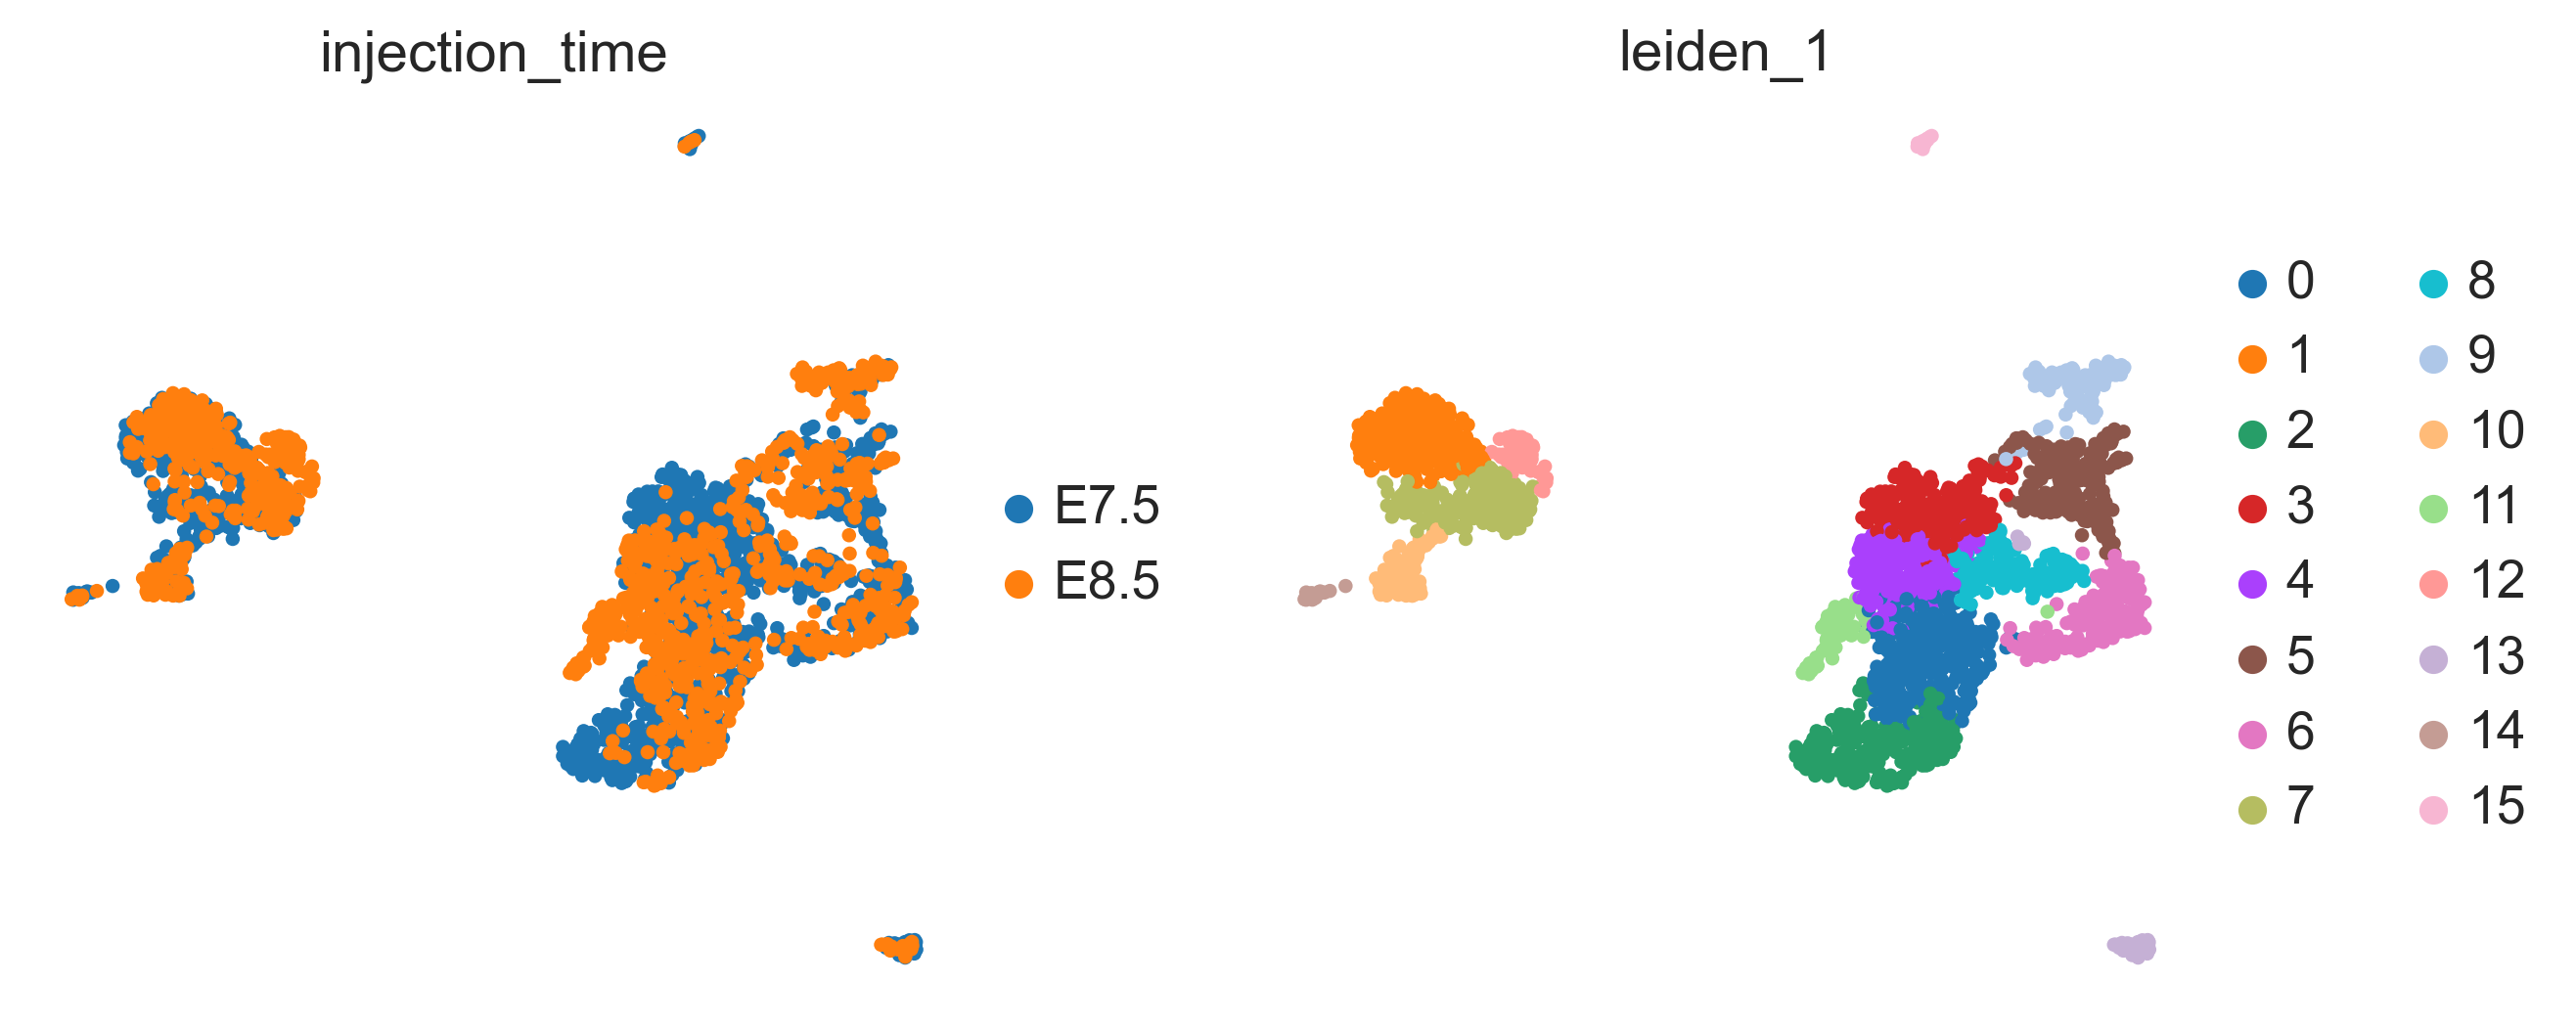

In [126]:
sc.pl.umap(clones, color=["injection_time", "leiden_1"], frameon=False)

In [22]:
clone_to_gRNA = {}
for clone, gRNA in zip(adata_clonal.obs["clones"], adata_clonal.obs["CRISPR:predicted"]):
    if str(gRNA) == "nan":
        gRNA = "NA"
    if "|" in str(gRNA):
        gRNA = "multi_gRNA"
    if "injection19" in clone:
        gRNA = "Etoh"
    if clone in clone_to_gRNA:
        if clone_to_gRNA[clone] != gRNA:
            print(clone)
    else:
        clone_to_gRNA[clone] = gRNA
clones.obs["perturbation"] = [clone_to_gRNA[clone] for clone in clones.obs_names]

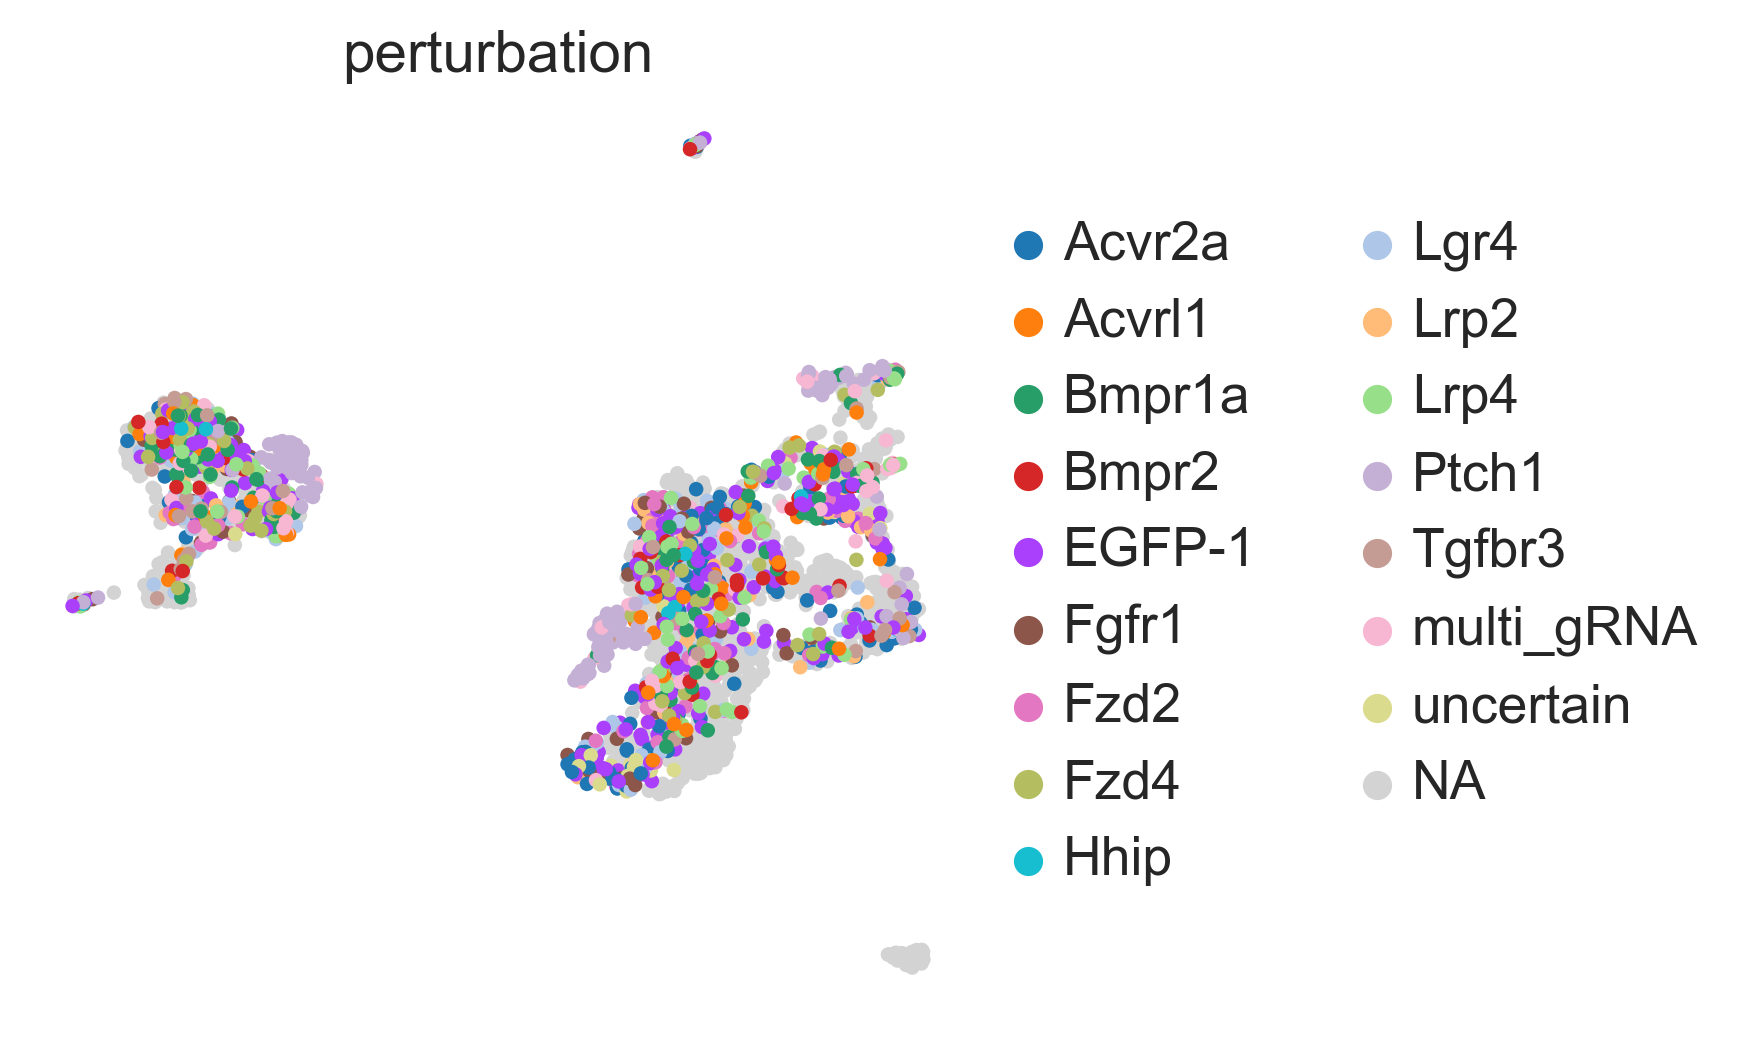

In [28]:
clones_to_draw = [clone for clone in set(clones.obs["perturbation"]) if clone != "NA"]
sc.pl.umap(clones, color=["perturbation"], frameon=False, groups=clones_to_draw)

In [43]:
clones.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_clone2vec.h5ad")

In [103]:
for adata_ in [adata_m, adata_g, adata_o, adata_n, adata]:
    for leiden in [0.5, 1, 2]:
        clones_dict = dict(clones.obs[f"leiden_{leiden}"])
        
        adata_.obs[f"clones_clusters_{leiden}"] = [
            clones_dict[E7] if ((E7 in clones_dict) and (E8 not in clones_dict)) else
            clones_dict[E8] if ((E7 not in clones_dict) and (E8 in clones_dict)) else
            "NA" if ((E7 not in clones_dict) and (E8 not in clones_dict)) else
            clones_dict[E7] if ((clones_dict[E7] == clones_dict[E8])) else
            "conflict" for E7, E8 in zip(
                "E7.5:" + adata_.obs["E7.5:clones"].astype(str).values,
                "E8.5:" + adata_.obs["E8.5:clones"].astype(str).values,
            )
        ]

In [112]:
adata.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_merged.h5ad")
adata_m.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_mesenchyme_merged.h5ad")
adata_n.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_neurons_merged.h5ad")
adata_g.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_glia_merged.h5ad")
adata_o.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/trunk_other_merged.h5ad")

## Ptch1 statisctics

### Approximating variance for Beta-regression

In [628]:
clones.obs["injection"] = list(pd.Series(clones.obs.index).apply(lambda x: x.split(":")[1]))

whitelist = ["Acvr2a", "Fgfr1", "Fzd2", "Lgr4", "Lrp2", "EGFP-1"]
proportions = {}

for injection in ["injection8", "injection9", "injection10"]:
    proportions[injection] = clones[clones.obs.injection == injection].obs.groupby(["leiden_1", "perturbation"]).size().unstack()[whitelist]
    proportions[injection] += 0
    proportions[injection] = (proportions[injection] / proportions[injection].sum(axis=0))

In [629]:
from scipy.stats import beta

variances = []
means = []
clonal_clusters = []
gRNAs = []

for clonal_cluster in ["0", "1", "2", "3", "4", "5", "6", "7"]:
    for gRNA in whitelist:
        gRNA_props = [proportions[injection][gRNA][clonal_cluster] for injection in ["injection8", "injection9", "injection10"]]
        gRNA_props = np.array(gRNA_props)
        gRNA_props = gRNA_props[gRNA_props != 0]
        try:
            a, b, *props = beta.fit(gRNA_props, floc=0., fscale=1.)
            mean, var = beta.stats(a, b, moments="mv")

            variances.append(var)
            means.append(mean)
            gRNAs.append(gRNA)
            clonal_clusters.append(clonal_cluster)
        except:
            print("Fit error")

Fit error
Fit error
Fit error
Fit error
Fit error


In [630]:
from scipy.optimize import curve_fit, root

def f(x, a, b):
    return a * (x ** 2) + b * x

a, b = curve_fit(f, means, variances)[0]

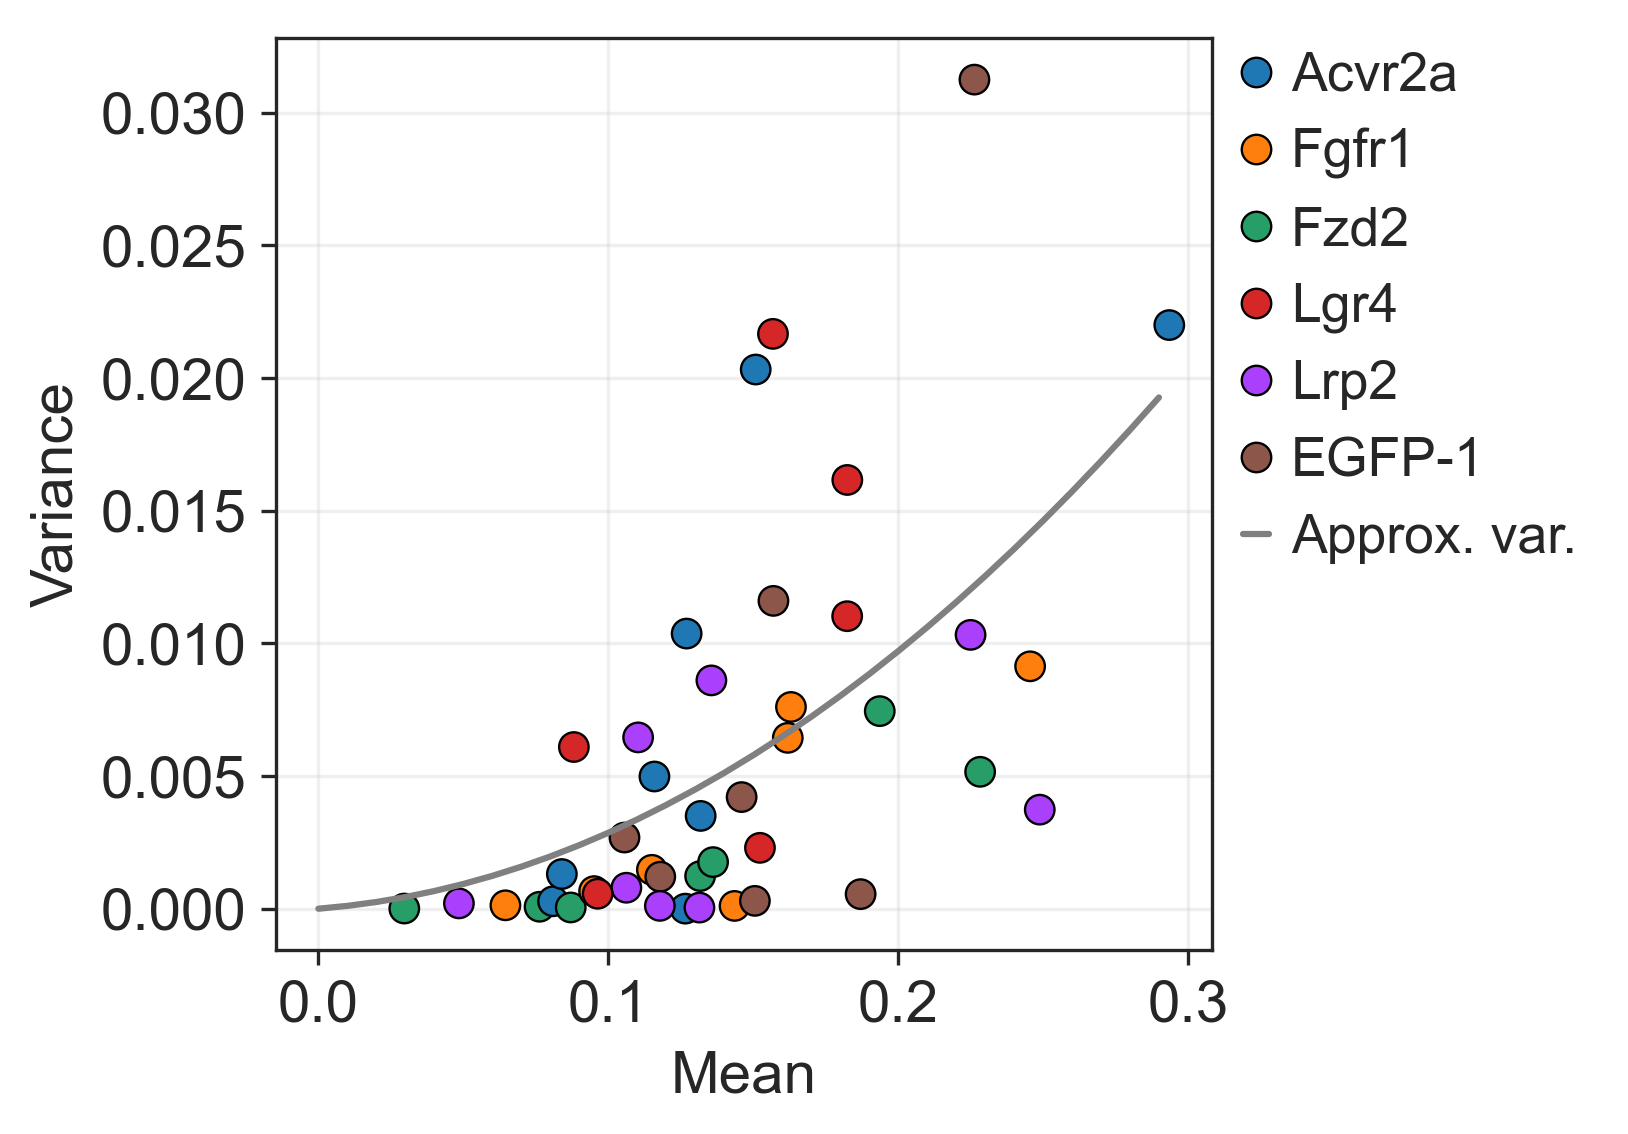

In [631]:
ax = sns.scatterplot(
    x=means,
    y=variances,
    hue=gRNAs,
    s=50,
    edgecolor="black",
)

ax = sns.lineplot(
    x=np.arange(0, 0.3, 0.01),
    y=f(np.arange(0, 0.3, 0.01), a, b),
    color="grey",
    label="Approx. var.",
)

ax.grid(alpha=0.3)
ax.set_xlabel("Mean")
ax.set_ylabel("Variance")
ax.legend(loc=(1.01, 0.4))

In [632]:
# Test for EGFPs in different replicates

clonal_cluster = "1"

mean_L1 = proportions["injection8"]["EGFP-1"][clonal_cluster]
mean_L0 = proportions["injection9"]["EGFP-1"][clonal_cluster]

var_L1 = f(mean_L1, a, b)
var_L0 = f(mean_L0, a, b)

alpha_L1, beta_L1 = root(f_beta, [1, 1], args=(mean_L1, var_L1)).x
alpha_L0, beta_L0 = root(f_beta, [1, 1], args=(mean_L0, var_L0)).x

L0 = np.log(beta.pdf(mean_L1, alpha_L0, beta_L0, loc=0, scale=1))
L1 = np.log(beta.pdf(mean_L1, alpha_L1, beta_L1, loc=0, scale=1))
Λ = -2 * (L0 - L1)
pvalue = 1 - chi2(1).cdf(Λ)

print(pvalue)

0.11899374656309114


### Estimating parameters for Beta distribution

In [673]:
proportions = clones[clones.obs.injection == "injection18"].obs.groupby(["leiden_1", "perturbation"]).size().unstack()[["Ptch1", "EGFP-1"]]
proportions += 1
proportions = proportions / proportions.sum(axis=0)

proportions

perturbation,Ptch1,EGFP-1
leiden_1,,
0,0.011494,0.155963
1,0.034483,0.220183
2,0.005747,0.009174
3,0.011494,0.045872
4,0.005747,0.119266
5,0.017241,0.174312
6,0.040230,0.055046
7,0.040230,0.073394
8,0.005747,0.073394


In [674]:
Ptch1_mean_9 = proportions["Ptch1"]["9"]
Ptch1_mean_11 = proportions["Ptch1"]["11"]
Ptch1_mean_12 = proportions["Ptch1"]["12"]
EGFP_mean_9 = proportions["EGFP-1"]["9"]
EGFP_mean_11 = proportions["EGFP-1"]["11"]
EGFP_mean_12 = proportions["EGFP-1"]["12"]

Ptch1_var_9 = f(Ptch1_mean_9, a, b)
Ptch1_var_11 = f(Ptch1_mean_11, a, b)
Ptch1_var_12 = f(Ptch1_mean_12, a, b)
EGFP_var_9 = f(EGFP_mean_9, a, b)
EGFP_var_11 = f(EGFP_mean_11, a, b)
EGFP_var_12 = f(EGFP_mean_12, a, b)

In [675]:
def f_beta(x, mu, var):
    alpha, beta = x[0], x[1]
    return [alpha / (alpha + beta) - mu, (alpha * beta) / (((alpha + beta) ** 2) * (alpha + beta + 1)) - var]

alpha_EGFP_9, beta_EGFP_9 = root(f_beta, [1, 1], args=(EGFP_mean_9, EGFP_var_9)).x
alpha_EGFP_11, beta_EGFP_11 = root(f_beta, [1, 1], args=(EGFP_mean_11, EGFP_var_11)).x
alpha_EGFP_12, beta_EGFP_12 = root(f_beta, [1, 1], args=(EGFP_mean_12, EGFP_var_12)).x

alpha_Ptch1_9, beta_Ptch1_9 = root(f_beta, [1, 1], args=(Ptch1_mean_9, Ptch1_var_9)).x
alpha_Ptch1_11, beta_Ptch1_11 = root(f_beta, [1, 1], args=(Ptch1_mean_11, Ptch1_var_11)).x
alpha_Ptch1_12, beta_Ptch1_12 = root(f_beta, [1, 1], args=(Ptch1_mean_12, Ptch1_var_12)).x

In [678]:
# Test for cluster 9

from scipy.stats import chi2

L0 = np.log(beta.pdf(proportions["Ptch1"]["9"], alpha_EGFP_9, beta_EGFP_9, loc=0, scale=1))
L1 = np.log(beta.pdf(proportions["Ptch1"]["9"], alpha_Ptch1_9, beta_Ptch1_9, loc=0, scale=1))
Λ = -2 * (L0 - L1)
pvalue = 1 - chi2(1).cdf(Λ)

print(pvalue)

4.3878578370737387e-07


In [676]:
# Test for cluster 11

from scipy.stats import chi2

L0 = np.log(beta.pdf(proportions["Ptch1"]["11"], alpha_EGFP_11, beta_EGFP_11, loc=0, scale=1))
L1 = np.log(beta.pdf(proportions["Ptch1"]["11"], alpha_Ptch1_11, beta_Ptch1_11, loc=0, scale=1))
Λ = -2 * (L0 - L1)
pvalue = 1 - chi2(1).cdf(Λ)

print(pvalue)

1.609823385706477e-14


In [677]:
# Test for cluster 12

from scipy.stats import chi2

L0 = np.log(beta.pdf(proportions["Ptch1"]["12"], alpha_EGFP_12, beta_EGFP_12, loc=0, scale=1))
L1 = np.log(beta.pdf(proportions["Ptch1"]["12"], alpha_Ptch1_12, beta_Ptch1_12, loc=0, scale=1))
Λ = -2 * (L0 - L1)
pvalue = 1 - chi2(1).cdf(Λ)

print(pvalue)

7.061018436615996e-14


### scCODA

In [667]:
import sccoda
from sccoda.util import cell_composition_data as dat
from sccoda.util import comp_ana as mod

subset = clones[clones.obs.injection == "injection18"]
subset = subset[subset.obs.perturbation.isin(["EGFP-1", "Ptch1"])]
subset = dat.from_scanpy(
    subset,
    cell_type_identifier="leiden_1",
    sample_identifier="perturbation",
)
subset.obs["covariate"] = list(subset.obs.index)

model = mod.CompositionalAnalysis(subset, formula="covariate", reference_cell_type="1")
sim_results = model.sample_hmc()

No covariate information specified!
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:24<00:00, 97.91it/s] 


MCMC sampling finished. (258.810 sec)
Acceptance rate: 60.2%


In [688]:
sim_results.set_fdr(est_fdr=1e-5)
print(sim_results.credible_effects())

Covariate           Cell Type
covariate[T.Ptch1]  0            False
                    1            False
                    3            False
                    4            False
                    5            False
                    6            False
                    7            False
                    8            False
                    9             True
                    10           False
                    11            True
                    12            True
                    14           False
                    15           False
Name: Final Parameter, dtype: bool


Text(0.5, 0, '')

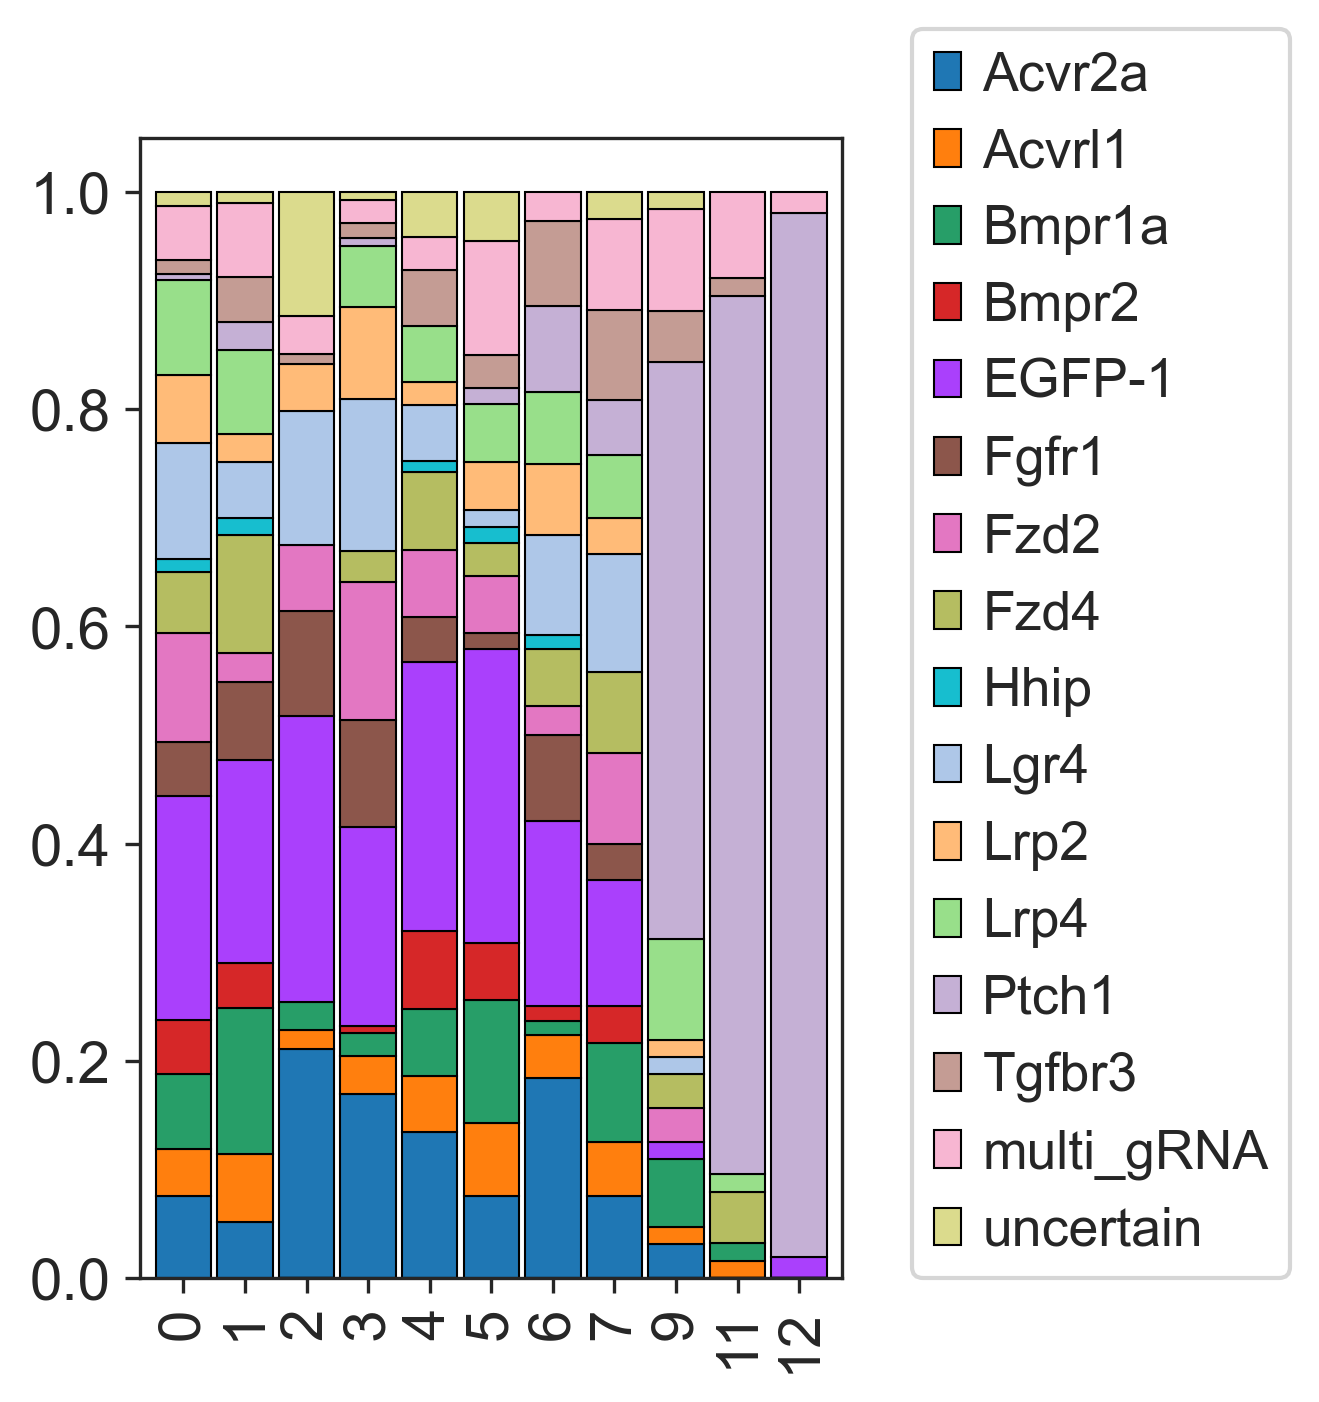

In [616]:
clonal_cluster_count = clones.obs.groupby(["leiden_1", "perturbation"]).size().reset_index().pivot(
    columns="perturbation", index="leiden_1", values=0
)
clonal_cluster_count = clonal_cluster_count[clonal_cluster_count.columns[clonal_cluster_count.columns != "NA"]]
clonal_cluster_count = clonal_cluster_count[clonal_cluster_count.sum(axis=1) > 50]
clonal_cluster_count = (clonal_cluster_count.T / clonal_cluster_count.sum(axis=1)).T

fig, ax = plt.subplots(figsize=(3, 5))
ax = clonal_cluster_count.plot(kind="bar", stacked=True, width=0.9, edgecolor="black",
                               color=dict(zip(clones.obs.perturbation.cat.categories, clones.uns["perturbation_colors"])),
                               ax=ax, linewidth=0.5)
ax.legend(loc=(1.1, 0))
ax.set_xlabel("")

# Face

In [113]:
adata_m = sc.read_h5ad(f"{DATA_PATH}/anndatas/mesenchyme_face_E13_reference.h5ad")
adata_m = adata_m[~adata_m.obs.celltype_l2.isin(["Doublets", "Doublet"])]

adata_n = sc.read_h5ad(f"{DATA_PATH}/anndatas/neurons_glia_face_E13_reference.h5ad")
adata_n = adata_n[~adata_n.obs.celltype_l2.isin(["Doublets", "Doublet"])]

adata_o = sc.read_h5ad(f"{DATA_PATH}/anndatas/other_cells_face_E13_reference.h5ad")
adata_o = adata_o[~adata_o.obs.celltype_l2.isin(["Doublets", "Doublet"])]

adata = sc.read_h5ad(f"{DATA_PATH}/anndatas/face_E13_reference.h5ad")
adata = adata[~adata.obs.celltype_l2.isin(["Doublets", "Doublet"])]

for adata_ in [adata, adata_o, adata_m, adata_n]:
    adata_.obs["perturbation"] = "False"

In [114]:
adata_n_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/face_E13_neurons_and_glia.h5ad")
adata_o_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/face_E13_other.h5ad")
adata_m_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/face_E13_mesenchyme.h5ad")

adata_full_crispr = sc.read_h5ad(f"{DATA_PATH}/anndatas/perturbations_noEtOH/face_E13.h5ad")

adata_o_crispr = adata_o_crispr[~adata_o_crispr.obs.celltype_l2.isin(["Doublets", "Doublet"])]
adata_n_crispr = adata_n_crispr[~adata_n_crispr.obs.celltype_l2.isin(["Doublets", "Doublet"])]
adata_m_crispr = adata_m_crispr[~adata_m_crispr.obs.celltype_l2.isin(["Doublets", "Doublet"])]

adata_full_crispr = adata_full_crispr[~adata_full_crispr.obs.celltype_l2.isin(["Doublets", "Doublet"])]

for adata_ in [adata_full_crispr, adata_o_crispr, adata_m_crispr, adata_n_crispr]:
    adata_.obs["perturbation"] = "True"

In [115]:
adata_n = adata_n.raw.to_adata().concatenate(adata_n_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata_m = adata_m.raw.to_adata().concatenate(adata_m_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata_o = adata_o.raw.to_adata().concatenate(adata_o_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)
adata = adata.raw.to_adata().concatenate(adata_full_crispr, batch_key=None, join="outer", fill_value=0, index_unique=None)

for adata_ in [adata, adata_o, adata_m, adata_n]:
    adata_.var = pd.DataFrame(index=adata_.var_names)
    adata_.obs["E7.5:clones"] = adata_.obs["E7.5:clones"].fillna("NA")
    adata_.obs["E8.5:clones"] = adata_.obs["E8.5:clones"].fillna("NA")

## Joint clonal analysis from both stages

In [116]:
clonal_nn_kwargs = {
    "obs_name": "clones",
    "obsm_name": "X_pca_harmony",
    "min_size": 5,
}

adata_m_fake = create_fake_anndata(adata_m)
adata_o_fake = create_fake_anndata(adata_o)
adata_n_fake = create_fake_anndata(adata_n)

adata_m_clonal = sl.tl.clonal_nn(adata_m_fake, **clonal_nn_kwargs)
adata_n_clonal = sl.tl.clonal_nn(adata_n_fake, **clonal_nn_kwargs)
adata_o_clonal = sl.tl.clonal_nn(adata_o_fake, **clonal_nn_kwargs)

adata_clonal = adata_m_clonal.concatenate(
    [adata_n_clonal, adata_o_clonal],
    join="outer",
    batch_key=None,
    index_unique=None,
    fill_value=0,
)

for ct in ["celltype_l2", "celltype_l3", "CRISPR:predicted"]:
    ct_list = []
    for adata_ in [adata_m_fake, adata_n_fake, adata_o_fake]:
        ct_list += list(adata_.obs[ct].astype(str))
    adata_clonal.obs[ct] = ct_list
    adata_clonal.obs[ct] = adata_clonal.obs[ct].astype("category")

clones = sl.tl.clone2vec(
    adata_clonal,
    obs_name=f"clones",
    device="cuda:0",
    fill_ct="celltype_l2",
)

sc.pp.neighbors(clones, use_rep="word2vec")
sc.tl.umap(clones)
clones.obs["injection_time"] = [i.split(":")[0] for i in clones.obs_names]

100%|██████████| 200/200 [47:13<00:00, 14.17s/it]


In [131]:
sc.tl.umap(clones, min_dist=0.3)

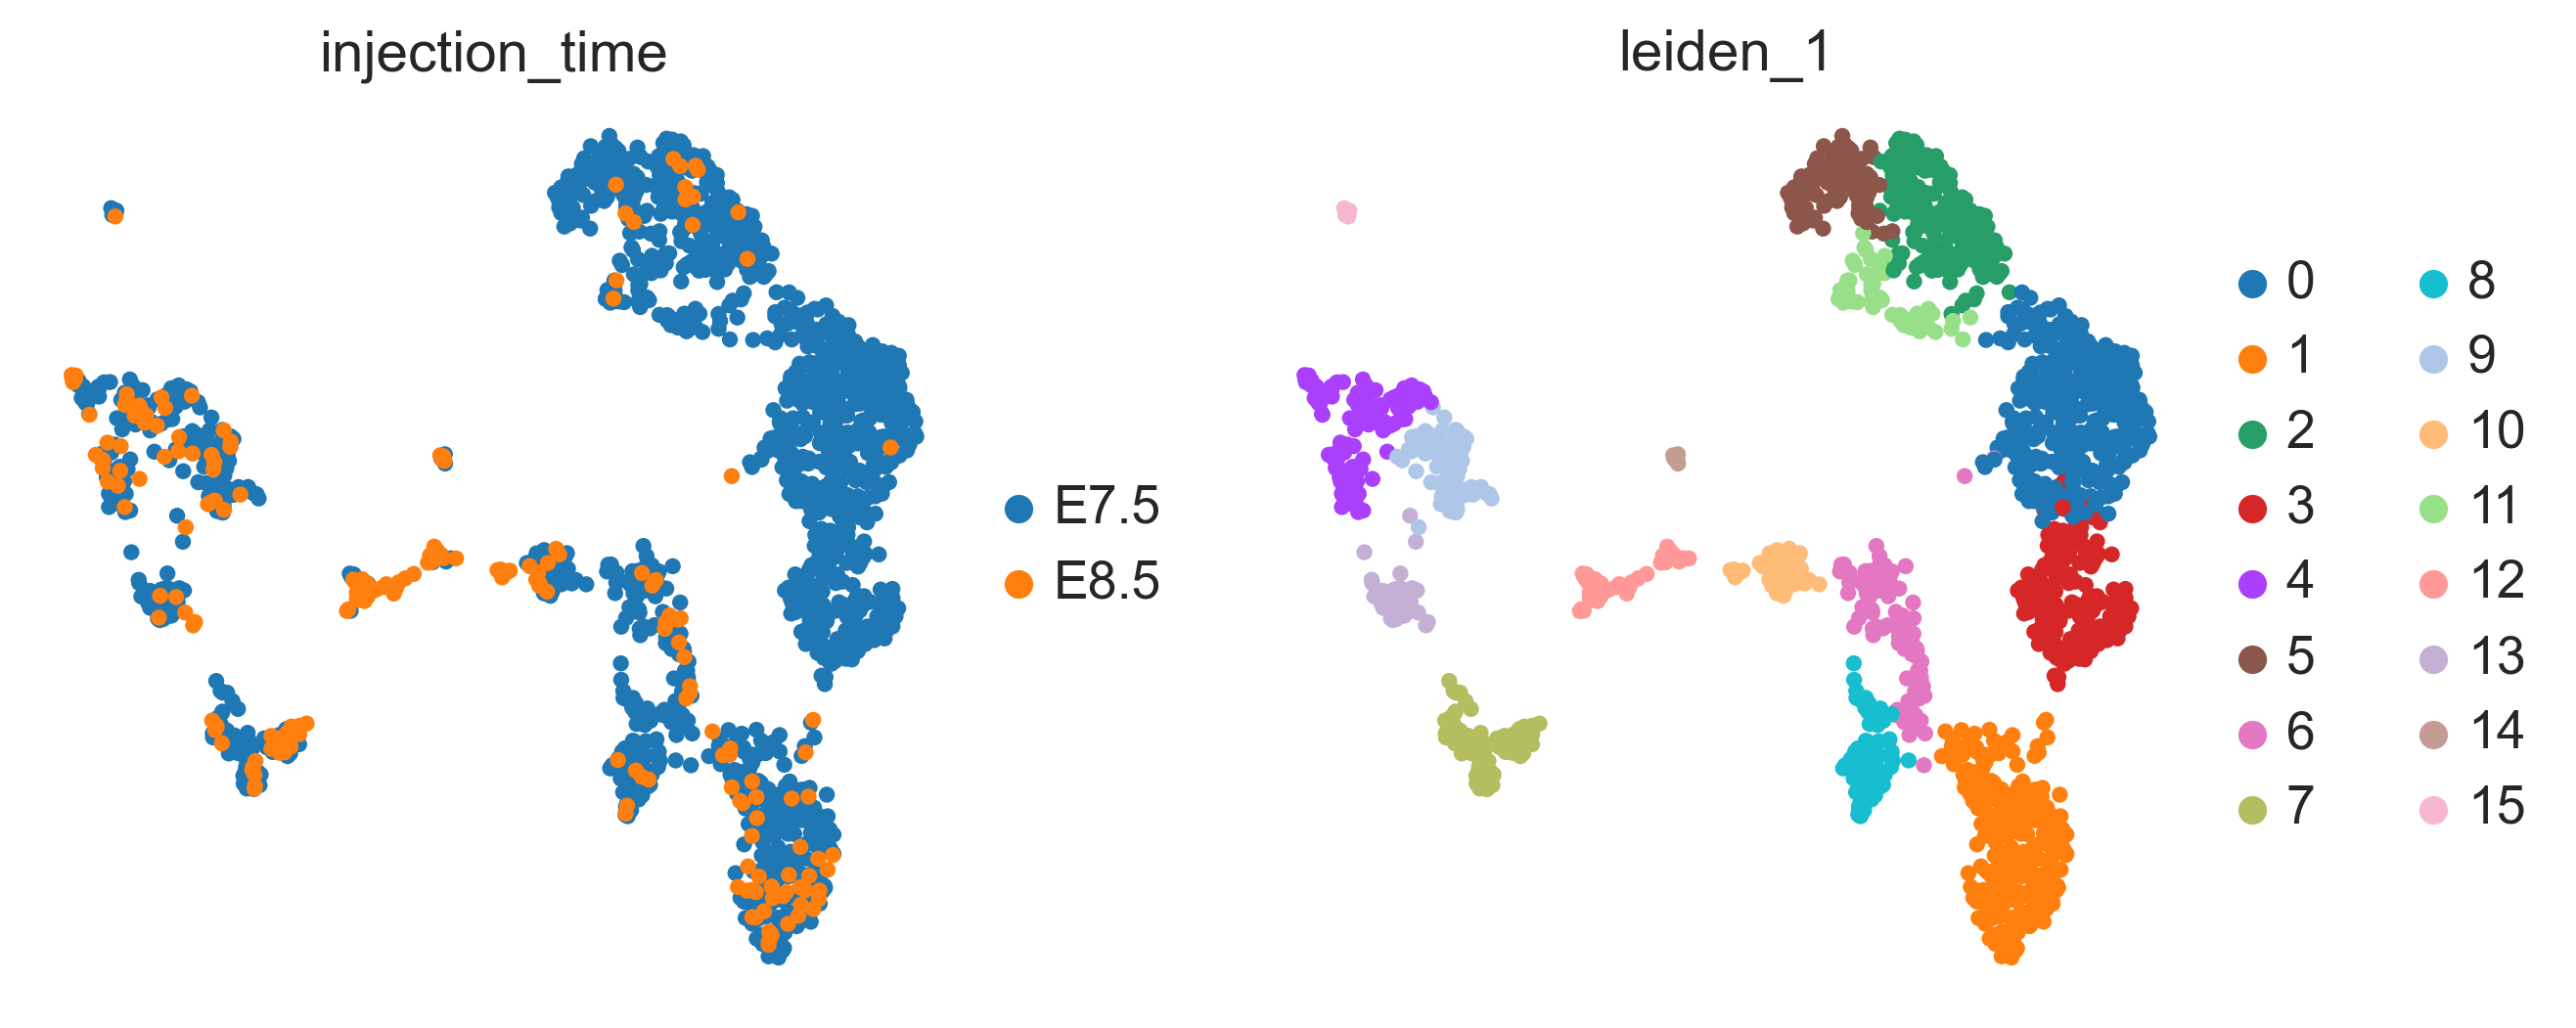

In [137]:
for resolution in [0.5, 1, 2]:
    sc.tl.leiden(
        clones,
        resolution=resolution,
        key_added=f"leiden_{resolution}",
    )
sc.pl.umap(clones, color=["injection_time", "leiden_1"], frameon=False)

In [134]:
clone_to_gRNA = {}
for clone, gRNA in zip(adata_clonal.obs["clones"], adata_clonal.obs["CRISPR:predicted"]):
    if str(gRNA) == "nan":
        gRNA = "NA"
    if "|" in str(gRNA):
        gRNA = "multi_gRNA"
    if "injection19" in clone:
        gRNA = "Etoh"
    if clone in clone_to_gRNA:
        if clone_to_gRNA[clone] != gRNA:
            print(clone)
    else:
        clone_to_gRNA[clone] = gRNA
clones.obs["perturbation"] = [clone_to_gRNA[clone] for clone in clones.obs_names]

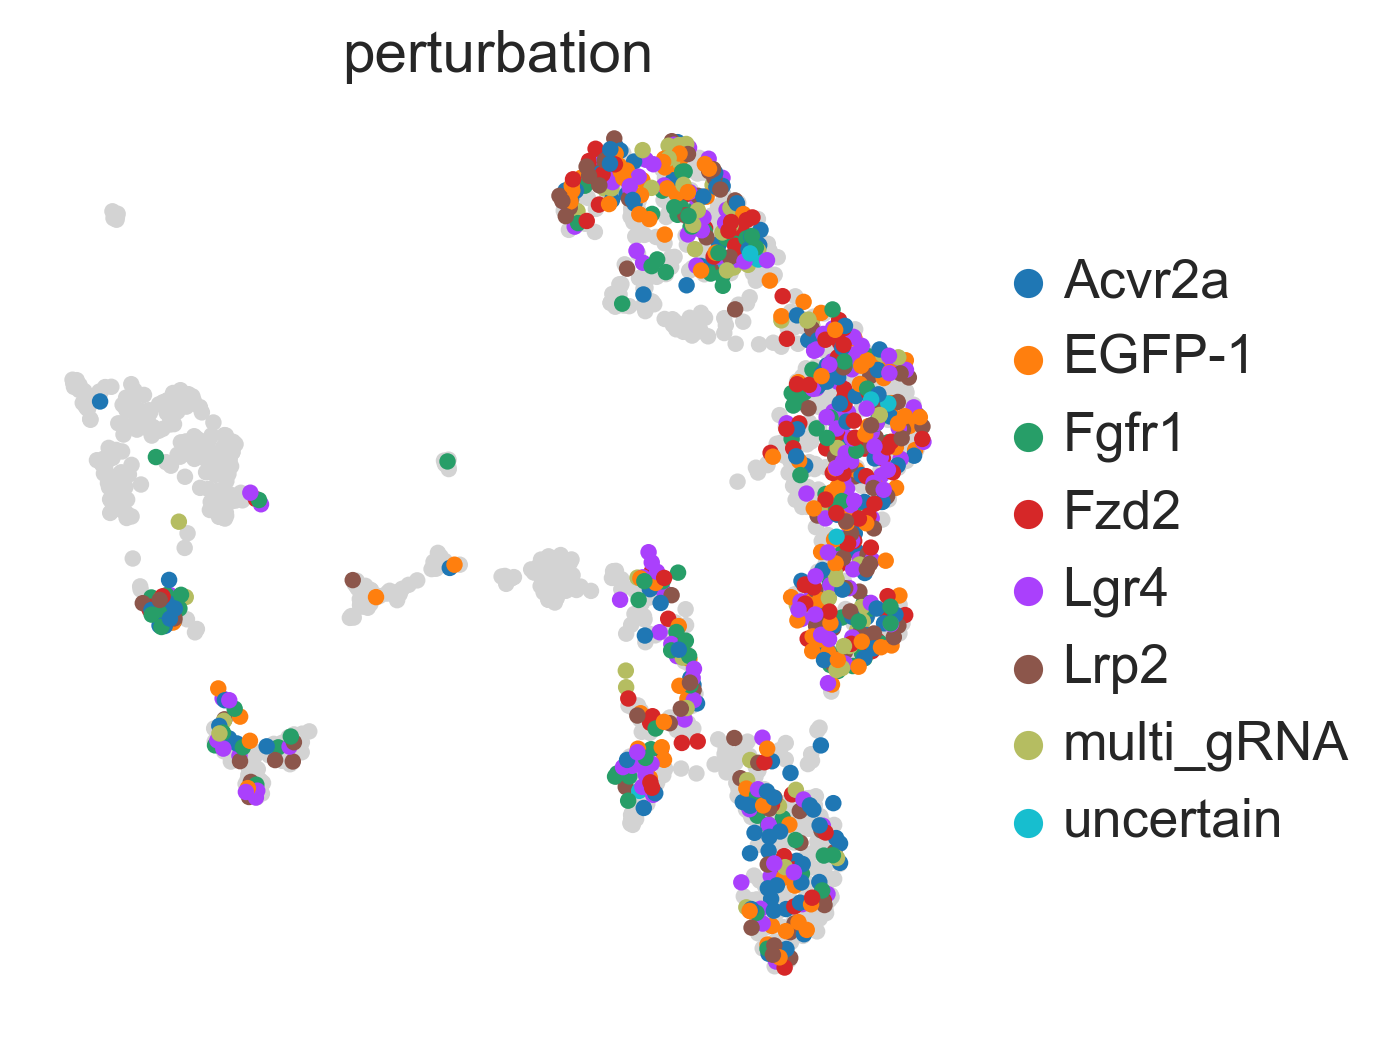

In [135]:
clones_to_draw = [clone for clone in set(clones.obs["perturbation"]) if clone != "NA"]
sc.pl.umap(clones, color=["perturbation"], frameon=False, groups=clones_to_draw, na_in_legend=False)

Text(0.5, 0, '')

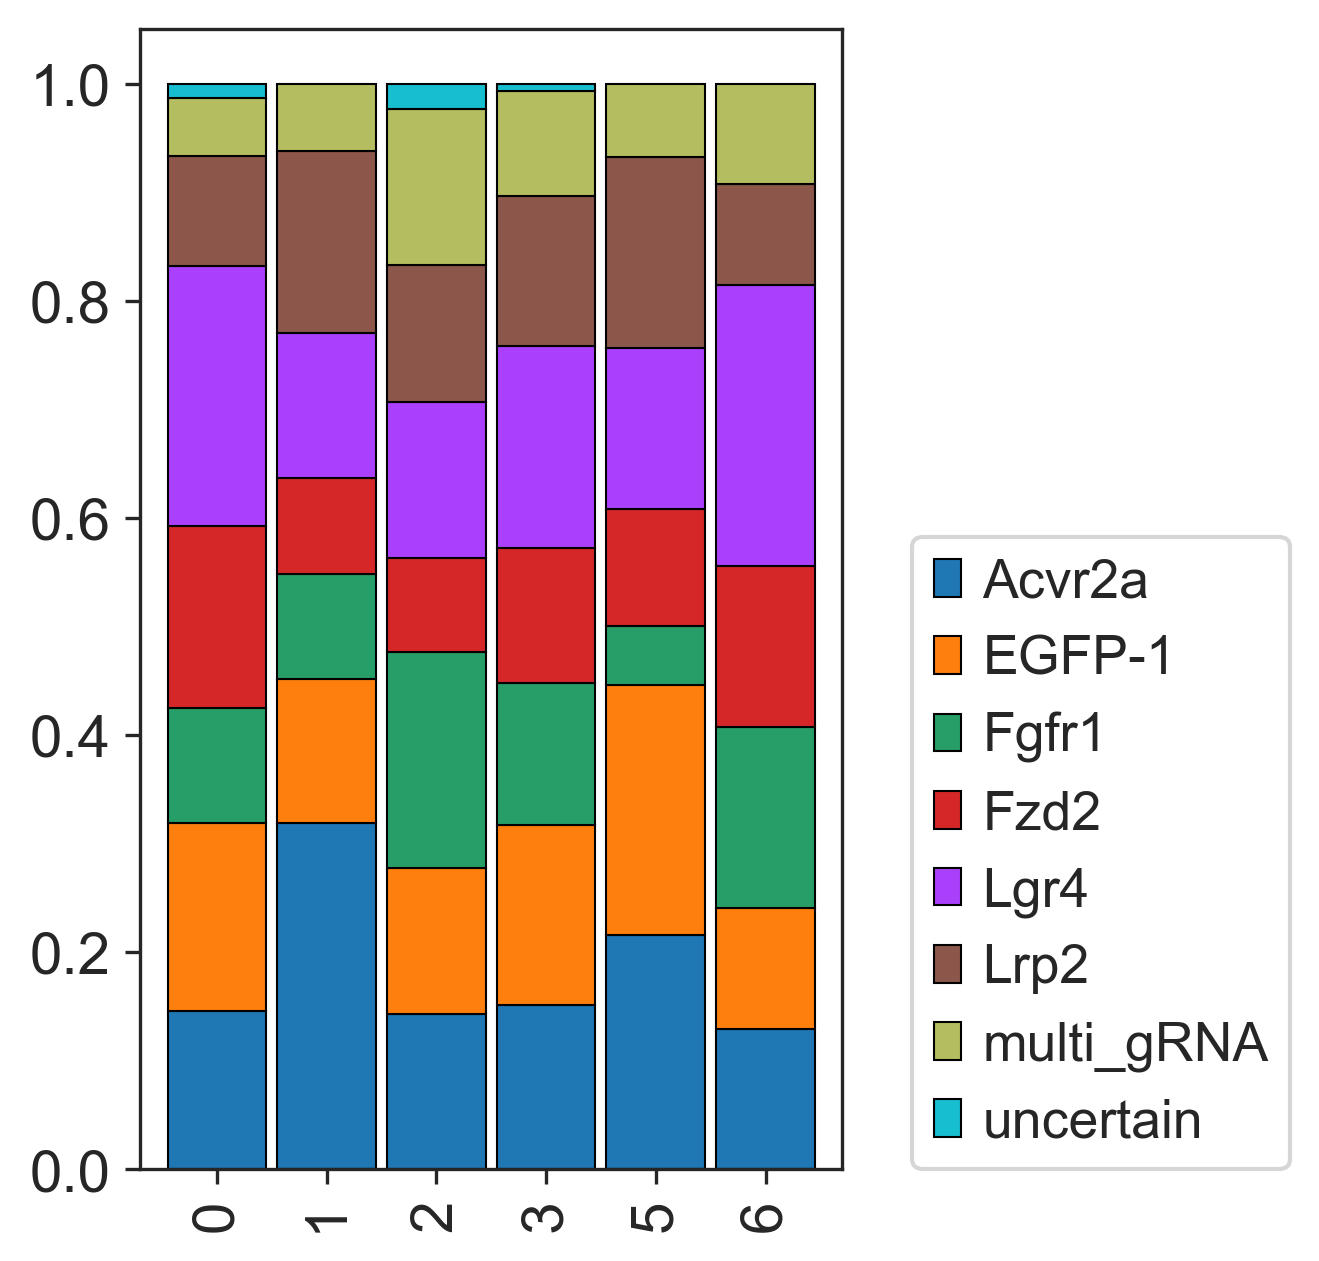

In [151]:
clonal_cluster_count = clones.obs.groupby(["leiden_1", "perturbation"]).size().reset_index().pivot(
    columns="perturbation", index="leiden_1", values=0
)
clonal_cluster_count = clonal_cluster_count[clonal_cluster_count.columns[clonal_cluster_count.columns != "NA"]]
clonal_cluster_count = clonal_cluster_count[clonal_cluster_count.sum(axis=1) > 50]
clonal_cluster_count = (clonal_cluster_count.T / clonal_cluster_count.sum(axis=1)).T

fig, ax = plt.subplots(figsize=(3, 5))
ax = clonal_cluster_count.plot(kind="bar", stacked=True, width=0.9, edgecolor="black",
                               color=dict(zip(clones.obs.perturbation.cat.categories, clones.uns["perturbation_colors"])),
                               ax=ax, linewidth=0.5)
ax.legend(loc=(1.1, 0))
ax.set_xlabel("")

In [172]:
clones.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/face_clone2vec.h5ad")

In [153]:
for adata_ in [adata_m, adata_o, adata_n, adata]:
    for leiden in [0.5, 1, 2]:
        clones_dict = dict(clones.obs[f"leiden_{leiden}"])
        
        adata_.obs[f"clones_clusters_{leiden}"] = [
            clones_dict[E7] if ((E7 in clones_dict) and (E8 not in clones_dict)) else
            clones_dict[E8] if ((E7 not in clones_dict) and (E8 in clones_dict)) else
            "NA" if ((E7 not in clones_dict) and (E8 not in clones_dict)) else
            clones_dict[E7] if ((clones_dict[E7] == clones_dict[E8])) else
            "conflict" for E7, E8 in zip(
                "E7.5:" + adata_.obs["E7.5:clones"].astype(str).values,
                "E8.5:" + adata_.obs["E8.5:clones"].astype(str).values,
            )
        ]

In [173]:
adata.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/face_merged.h5ad")
adata_m.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/face_mesenchyme_merged.h5ad")
adata_n.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/face_neurons_merged.h5ad")
adata_o.write_h5ad("/home/sergey/data/clonal_project/anndatas/perturbations_noEtOH/clone2vec/face_other_merged.h5ad")